In [1]:
import xml.etree.ElementTree as ET
import string
import os  
import re
import pandas as pd

In [2]:
train_data_1 = pd.read_csv("OpenVirus-merged.csv")
train_data = train_data_1.iloc[1:] #remove the first row because it appears as data but is acually the title only 
train_data = train_data.sample(frac=1).reset_index(drop=True)  #shufffle the dataset

#train_data_1 = train_data_1.iloc[1:] #remove the first row because it appears as data but is acually the title only 
#train_data = train_data_1.sample(frac=1).reset_index(drop=True)  #shufffle the dataset

In [3]:
train_data.head() #visualizing the data table

,ArticleId,Text,Category
0,PMC6200010,french polynesia was the most probable source ...,viral_epidemic
1,PMC6142641,one of the viral diseases of zoonotic concern ...,viral_epidemic
2,PMC6538675,avian influenza ai is a highly contagious vi...,viral_epidemic
3,PMC7305475,with the recent development of multiple tools ...,viral_epidemic
4,PMC6538675,undoubtedly the rapid and continuous evolutio...,viral_epidemic


In [4]:
train_data['category_id'] = train_data['Category'].factorize()[0] # factorizing the output into zero and one

In [5]:
train_data.groupby('Category').category_id.count().plot.bar(ylim=0)

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer # term frequency & inverse document frequency (finding important words within text)
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=7, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')
features = tfidf.fit_transform(train_data.Text).toarray()
labels = train_data.category_id

In [59]:
category_to_id = {'true':0, 'false':1}
id_to_category = {0: 'true', 1: 'fasle'}

In [60]:
# Use chi-square analysis to find corelation between features (importantce of words) and labels(news category) 
from sklearn.feature_selection import chi2
import numpy as np

N = 3  # We are going to look for top 3 categories

#For each category, find words that are highly corelated to it
for Category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)                   # Do chi2 analyses of all items in this category
  indices = np.argsort(features_chi2[0])                                  # Sorts the indices of features_chi2[0] - the chi-squared stats of each feature
  feature_names = np.array(tfidf.get_feature_names())[indices]            # Converts indices to feature names ( in increasing order of chi-squared stat values)
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]         # List of single word features ( in increasing order of chi-squared stat values)
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]          # List for two-word features ( in increasing order of chi-squared stat values)
  print("# '{}':".format(Category))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:]))) # Print 3 unigrams with highest Chi squared stat
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:]))) # Print 3 bigrams with highest Chi squared stat

# 'false':
  . Most correlated unigrams:
       . media
       . swine
       . contagion
  . Most correlated bigrams:
       . zika virus
       . covid 19
       . sars cov
# 'true':
  . Most correlated unigrams:
       . media
       . swine
       . contagion
  . Most correlated bigrams:
       . zika virus
       . covid 19
       . sars cov


In [61]:
##dimension reduction 
from sklearn.manifold import TSNE #low dimensionality plot

# Sampling a subset of our dataset because t-SNE is computationally expensive
SAMPLE_SIZE = int(len(features) * 1)
np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)          # Randomly select 30 % of samples
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices]) # Array of all projected features of 30% of Randomly chosen samples 

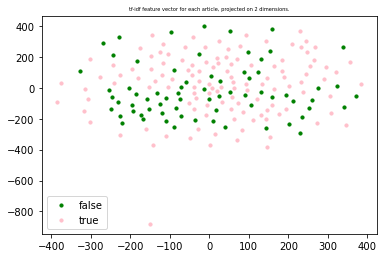

In [62]:
import matplotlib.pyplot as plt

colors = ['pink', 'green']

# Find points belonging to each category and plot them
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=10, c=colors[category_id], label=category)
plt.title("tf-idf feature vector for each article, projected on 2 dimensions.",
          fontdict=dict(fontsize=5))
plt.legend()

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score


models = [
    
    RandomForestClassifier(n_estimators=500, max_depth=4, random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    KNeighborsClassifier(n_neighbors=3)
]

In [64]:
CV = 5  # Cross Validate with 5 different folds of 20% data ( 80-20 split with 5 folds )

#Create a data frame that will store the results for all 5 trials of the 3 different models
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = [] # Initially all entries are empty

#For each Algorithm 
for model in models:
  model_name = model.__class__.__name__
  # create 5 models with different 20% test sets, and store their accuracies
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  # Append all 5 accuracies into the entries list ( after all 3 models are run, there will be 3x5 = 15 entries)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

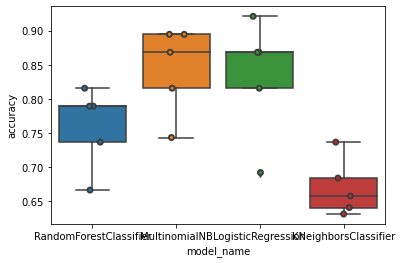

In [65]:
# Store the entries into the results dataframe and name its columns    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=5, jitter=True, edgecolor="gray", linewidth=2)

In [66]:
cv_df.groupby('model_name').accuracy.mean()

model_name
KNeighborsClassifier      0.670310
LogisticRegression        0.833198
MultinomialNB             0.843455
RandomForestClassifier    0.759649
Name: accuracy, dtype: float64

In [67]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.666667
1,RandomForestClassifier,1,0.789474
2,RandomForestClassifier,2,0.815789
3,RandomForestClassifier,3,0.736842
4,RandomForestClassifier,4,0.789474
5,MultinomialNB,0,0.743590
6,MultinomialNB,1,0.868421
7,MultinomialNB,2,0.894737
8,MultinomialNB,3,0.894737
9,MultinomialNB,4,0.815789


In [68]:
from sklearn.model_selection import train_test_split

model = RandomForestClassifier()

#Split Data 
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, train_data.index, test_size=0.33, random_state=0)

#Train Algorithm
model.fit(X_train, y_train)

# Make Predictions
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

In [69]:
category_id_df = train_data[['Category', 'category_id']].drop_duplicates().sort_values('category_id')

Text(0.5, 14.09375, 'Predicted')

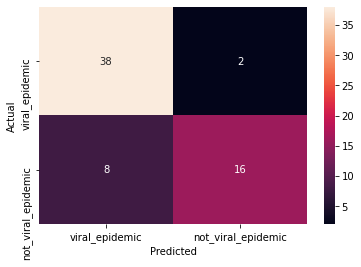

In [70]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
#run chi squared

In [46]:
from IPython.display import display

for predicted in category_id_df.category_id:
   for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 2:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(train_data.loc[indices_test[(y_test == actual) & (y_pred == predicted)]]['Text'])
      print('')

'fasle' predicted as 'true' : 4 examples.


157    this brings the focus back to the complexity o...
8      pandemics created by novel viruses from animal...
123    several factors of emergence have been identif...
173    ironically  covid has achieved  what was the u...
Name: Text, dtype: object


'true' predicted as 'fasle' : 9 examples.


71     one key factor that appears to be crucial in l...
169    some brief explanations of the basic concepts ...
153    the control of influenza a viruses in swine  i...
33     siamon gordon  frs  is an emeritus glaxo wellc...
26     to promote awareness of the existing or emergi...
139    equine influenza is a common  highly contagiou...
24     viral infections remain a global threat to wor...
176    beginning in late 2014 and into 2015  there we...
86     yu nong gong  rei lin kuo  guang wu chen  and ...
Name: Text, dtype: object

In [47]:
model2 = RandomForestClassifier()
model2.fit(features, labels)

RandomForestClassifier()